# Creating and extracting information from saliency maps
* organizing code
* removing multiclass case
* extract quantitative information from the maps

In [64]:
from prep_test_data import *
from pathlib import Path
import json
import torch
from matplotlib import pyplot as plt
import shutil
import numpy as np
import cv2
import csv

-------------------------------------------------------

## Main methods above

In [2]:
def create_maps_folders(main_folder, beat, labels, delete_prior):
    if delete_prior and Path(main_folder).exists():
        shutil.rmtree(main_folder)
    for label in labels:
        folder = Path(main_folder) / f"label_{beat}_beat/"
        Path(folder / label).mkdir(parents=True, exist_ok=True)
    return folder

In [3]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [48]:
def saliency_maps(model, data, main_folder, n_batches=None):
    classes = data["test"].dataset.classes
    i = 0
    for inputs, labels in data['test']:
        inputs = inputs.to(0)
        labels = labels.to(0)
        x = inputs
        x.requires_grad_();
        scores = model(x)
        score_max_index = scores.argmax(dim=1)

        score_max = scores[:, score_max_index]
        score_max.backward(torch.ones_like(score_max))
        saliency, _ = torch.max(x.grad.data.abs(),dim=1)
        
        #return saliency, x
        
        print(score_max_index)
        print(labels)
        for index in range(len(saliency)):
            sal = saliency[index].cpu().numpy()
            
            label = classes[labels[index]]
            true = labels[index]
            pred = score_max_index[index]
            pred_res = "OK"
            if pred != true:
                pred_res = "wrong"
            
            plt.figure()
            img1 = plt.imshow(sal, cmap=plt.cm.hot, alpha=.7);
            img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4);
            plt.axis('off')            
            plt.savefig(str(main_folder / f"{label}/{i}_{index}_{pred_res}.png"))
            plt.close();
                
        if n_batches:
            if i + 1 == n_batches:
                break
        i += 1
        
    return saliency, x

In [49]:
def create_saliency_maps_one_heartbeat(data_path, models_main_path, model_name, beat, saliency_maps_path, nr_egs):
    data_prep = DataPreparation(str(data_path))
    data, size = data_prep.create_dataloaders(16, False, 4)
    model_path = models_main_path / f"label_{beat}/{model_name}.pth"
    model = torch.load(model_path)
    model.eval();
    return saliency_maps(model, data, saliency_maps_path, nr_egs)

----------------------------------------------------------------

## Configuration and run methods!

In [50]:
with open("../config.json") as f:
    config_data = json.load(f)
    f.close()

In [51]:
HEARTBEAT = "final"
MODELS_PATH = Path(f"../models/")
MODEL_NAME = "resnet50_d_22_t_12_17"
MAP_DIR = "../attribution_maps/saliency_maps"
DELETE_PRIOR_DIR = True
TEST_DATA_PATH = Path(f'/mnt/Media/bernardo/DSL_test_data')
NR_BATCHES = 1

In [52]:
saliency_folder = create_maps_folders(MAP_DIR, HEARTBEAT, config_data['labels_bin'], DELETE_PRIOR_DIR)
saliency, imgs = create_saliency_maps_one_heartbeat(TEST_DATA_PATH, MODELS_PATH, MODEL_NAME, HEARTBEAT, saliency_folder, NR_BATCHES)

tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


## Digging into saliency maps and data

## It's important to differentiate the cases where the model gives the correct prediction from those where the prediction is wrong

In [40]:
i = 15
sal = saliency[i].cpu().numpy() # saliency for one sample
img = imgs[i]

In [21]:
sal.shape

(224, 224)

In [22]:
np.max(sal)

1.4449899

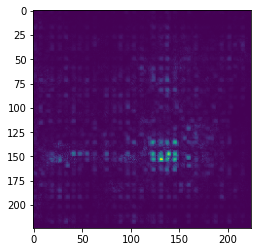

In [23]:
plt.imshow(sal)

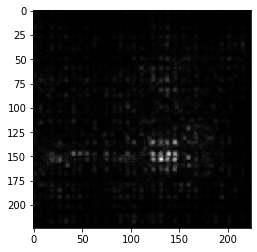

In [33]:
sal_trans = np.uint8(np.interp(sal, (np.min(sal), np.max(sal)), (0,255)))
plt.imshow(cv2.cvtColor(sal_trans, cv2.COLOR_BGR2RGB))

In [28]:
sal_trans = np.uint8(np.interp(sal, (np.min(sal), np.max(sal)), (0,255)))

In [53]:
deprocess(img.cpu()).numpy()

AttributeError: 'Image' object has no attribute 'numpy'

# Verify ROIs

In [60]:
TEST_DATA_PATH = Path(f'/mnt/Media/bernardo/DSL_test_data')

In [61]:
roi_file_path = list((Path.cwd().parent / "ROI").glob("*.txt"))[0] # --> label initial

In [65]:
with open(roi_file_path) as rois:
    rois_reader = csv.reader(rois, delimiter='\t')
    for i, roi in enumerate(rois_reader):
        if i != 0:
            print(TEST_DATA_PATH / f"{roi[1]}_{roi[0]}.png")
        elif i == 20:
            break
        pri

['Patient', 'File', 'bottom', 'top', 'left', 'right']
['217', '0_0', '310', '134', '947', '1137']
['217', '1_0', '318', '137', '948', '1150']
['217', '2_0', '324', '139', '951', '1157']
['217', '3_0', '320', '137', '958', '1156']
['217', '4_0', '314', '140', '957', '1149']
['217', '5_0', '266', '142', '953', '1146']
['217', '6_0', '331', '148', '949', '1137']
['217', '7_0', '334', '148', '947', '1143']
['217', '8_0', '335', '145', '954', '1146']
['217', '9_0', '333', '145', '958', '1158']
['217', '10_0', '335', '146', '960', '1160']
['217', '11_0', '335', '146', '959', '1160']
['217', '12_0', '329', '147', '954', '1145']
['217', '13_0', '334', '145', '951', '1134']
['217', '14_0', '338', '146', '948', '1132']
['217', '15_0', '333', '152', '947', '1142']
['217', '16_0', '327', '154', '947', '1150']
['217', '17_0', '324', '152', '952', '1163']
['217', '18_0', '318', '148', '957', '1153']
['217', '19_0', '322', '154', '954', '1143']
['217', '20_0', '332', '157', '950', '1137']
['217', '21

In [63]:
lines

['Patient\tFile\tbottom\ttop\tleft\tright\n',
 '217\t0_0\t310\t134\t947\t1137\n',
 '217\t1_0\t318\t137\t948\t1150\n',
 '217\t2_0\t324\t139\t951\t1157\n',
 '217\t3_0\t320\t137\t958\t1156\n',
 '217\t4_0\t314\t140\t957\t1149\n',
 '217\t5_0\t266\t142\t953\t1146\n',
 '217\t6_0\t331\t148\t949\t1137\n',
 '217\t7_0\t334\t148\t947\t1143\n',
 '217\t8_0\t335\t145\t954\t1146\n',
 '217\t9_0\t333\t145\t958\t1158\n',
 '217\t10_0\t335\t146\t960\t1160\n',
 '217\t11_0\t335\t146\t959\t1160\n',
 '217\t12_0\t329\t147\t954\t1145\n',
 '217\t13_0\t334\t145\t951\t1134\n',
 '217\t14_0\t338\t146\t948\t1132\n',
 '217\t15_0\t333\t152\t947\t1142\n',
 '217\t16_0\t327\t154\t947\t1150\n',
 '217\t17_0\t324\t152\t952\t1163\n',
 '217\t18_0\t318\t148\t957\t1153\n',
 '217\t19_0\t322\t154\t954\t1143\n',
 '217\t20_0\t332\t157\t950\t1137\n',
 '217\t21_0\t340\t162\t946\t1142\n',
 '217\t22_0\t335\t152\t949\t1143\n',
 '217\t23_0\t328\t145\t955\t1155\n',
 '217\t24_0\t319\t143\t959\t1160\n',
 '217\t25_0\t320\t145\t962\t1159\n',
 '